In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import Dataset
from torch import Tensor
from abc import ABC, abstractmethod
from torch.nn.functional import relu
from torch.utils.data.dataloader import DataLoader
from tqdm.notebook import tqdm
import scipy.stats as st
from itertools import product


(-2.0, 2.0)

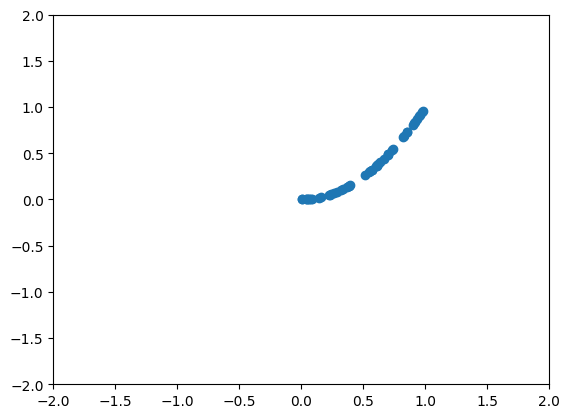

In [ ]:
def manifold_func(x):
    return x**2

N_SAMPLES = 50000
x = torch.rand(size=(N_SAMPLES,))
y = manifold_func(x)
data = torch.stack([x,y],axis=1)

fig, ax = plt.subplots()
ax.scatter(data[:50,0],data[:50,1])
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)

In [ ]:
from torch.utils.data import Dataset, DataLoader
class ManifoldDataset(Dataset):
    def __init__(self, data: torch.Tensor):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = data[idx]
        return data_item

dataset = ManifoldDataset(data)
batch_size = 128
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class ESDE():
    def __init__(self, T_max: float, rate: float = 1,sigma: float=1,dim: int=2):
        self.T_max = T_max
        self.rate = rate
        self.sigma=sigma
        self.dim = dim




    def sample_random_levels (self, length: int):

        return torch.distributions.Exponential(rate=self.rate).sample((length,))

    @staticmethod
    def _mult_first_dim(level,X):
        """
        Helper function to multiply one-dimensional noise level vector with tensor of
        arbitrary shape.
        Inputs:
            X_0: shape (n,*,*,...,*)
            t: shape (n)
        Outputs:
            has same shape as X_0 - inputs X_0[i] multipled with t[i]
        """
        return level.view(-1,*[1]*(X.dim()-1))*X

    def run_forward(self, X_0: Tensor, level: Tensor, clip_factor: float = 0.01):
        """
        Function to evolve SDE forward in time from 0 to t<=self.T_max.
        Assume that conditional distribution is Gaussian
        Inputs:
            X_0: shape (n,*,*,...,*)
            t: shape (n)
        Outputs:
            X_t: shape as X_0 - noised input
            noise: shape as X_0 - noise converting X_0 to X_t
            score: shape as X_0 - score of conditional distribution q_t|0(X_t|X_0)
        """
        noise = torch.randn(size=X_0.shape)
        X_t = (X_0+self.sigma*self._mult_first_dim(torch.sqrt(level),noise))
        if clip_factor is not None:
            level=torch.clip(level,min=clip_factor)
        score=-self.dim*self._mult_first_dim(1/(torch.sqrt(level)*self.sigma),noise)

        return X_t, noise,score

    def run_forward_random_times(self, X_0: Tensor):
        """Function to evolve SDE forward until random times."""
        levels = self.sample_random_levels(X_0.shape[0])
        X_t, noise,score= self.run_forward(X_0,levels)
        return X_t, noise,score

In [ ]:
sde = ESDE(T_max=1)

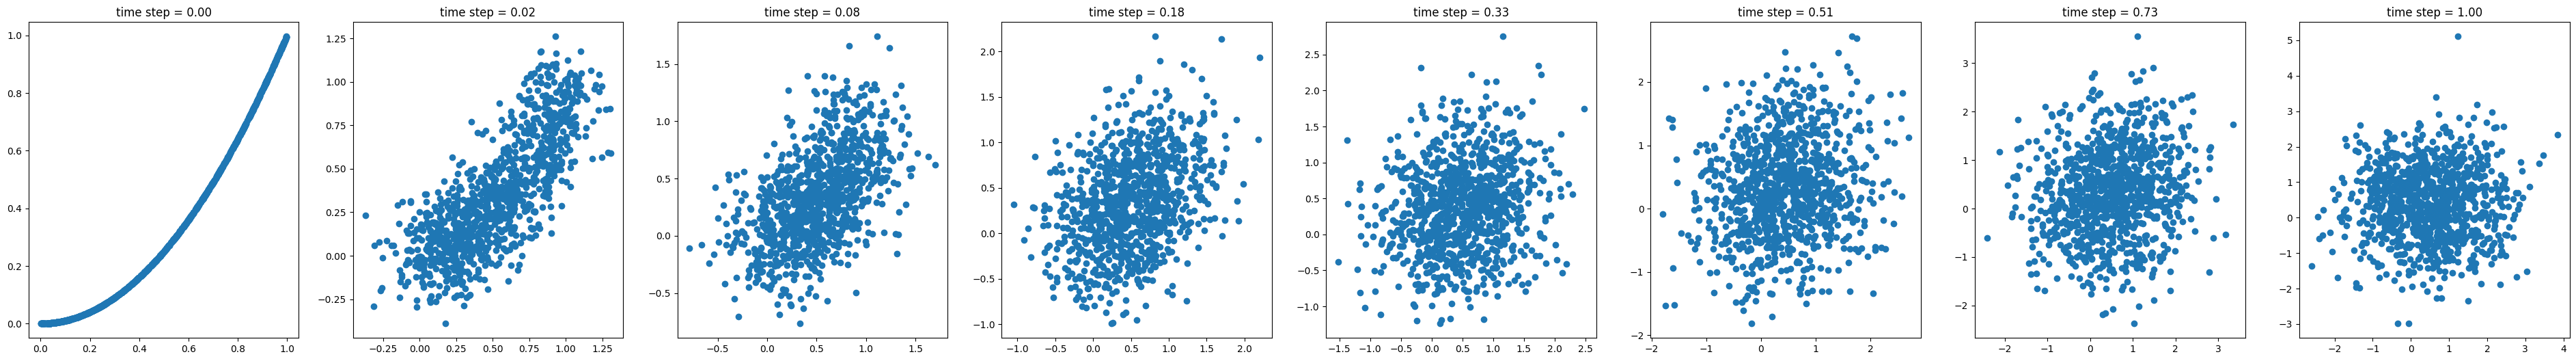

In [ ]:
n_grid_points = 8
time_vec = torch.linspace(0,1,n_grid_points)**2
X_0 = torch.stack([torch.stack([dataset.__getitem__(idx)]*n_grid_points) for idx in range(1000)]).transpose(1,0)
X_t, noise,score = sde.run_forward(X_0,time_vec)

fig, axs = plt.subplots(1,n_grid_points, figsize=(6*n_grid_points,6))
for idx in range(n_grid_points):
    axs[idx].scatter(X_t[idx,:,0],X_t[idx,:,1])

    axs[idx].set_title(f"time step = {time_vec[idx]:.2f}")

In [ ]:
TRAIN_SCORE = True #whether to train score or denoiser network


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullConnectedScoreModel(nn.Module):
    def __init__(self, data_dim: int = 2, hidden_dim: int = 128, n_hidden_layers: int = 2):
        super(FullConnectedScoreModel, self).__init__()

        # Input layer
        self.input_layer = nn.Linear(data_dim, hidden_dim)
        self.input_batch_norm = nn.BatchNorm1d(hidden_dim)

        # Hidden layers
        self.hidden_layers = nn.ModuleList()
        for _ in range(n_hidden_layers):
            layer = nn.Linear(hidden_dim, hidden_dim)
            batch_norm = nn.BatchNorm1d(hidden_dim)
            self.hidden_layers.append(nn.Sequential(layer, batch_norm))

        # Output layer
        self.output_layer = nn.Linear(hidden_dim, data_dim)  # Assuming output is a single value

    def forward(self, x):

        x = F.relu(self.input_batch_norm(self.input_layer(x)))

        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))

        return self.output_layer(x)

In [ ]:
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 1e-5
N_EPOCHS = 10
model = FullConnectedScoreModel().cuda() if torch.cuda.is_available() else FullConnectedScoreModel()
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY,maximize=False)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def train_diffusion_model(model, sde: ESDE, dataloader: DataLoader, optimizer, device, n_epochs: int, print_every: int, train_score: bool = TRAIN_SCORE):
    model.train()
    model = model.to(device)
    loss_function = nn.MSELoss(reduction='mean')
    running_loss_list = []

    for epoch in range(n_epochs):
        print(f"Epoch: {epoch}")
        running_loss = 0.0
        for idx, x_inp in enumerate(dataloader):

            #Zero gradients:
            optimizer.zero_grad()

            #Run forward samples:
            X_t,noise,score = sde.run_forward_random_times(x_inp)

            #Send to device:
            X_t = X_t.to(device)
            noise = noise.to(device)
            score = score.to(device)

            #Predict score:
            model_pred = model(X_t)

            #Compute loss:
            if train_score:
                loss = loss_function(score,model_pred)
            else:
                loss = loss_function(noise,model_pred)

            #Optimize:
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.detach().item()

            if (idx+1) % print_every == 0:
                avg_loss = running_loss/print_every
                running_loss_list.append(avg_loss)
                running_loss = 0.0
                print(avg_loss)
    return model,running_loss_list

In [ ]:
def plot_score_vector_field_modified(model=None, t=None, fpath=None, sde=None,
                                    min_x=-5.0, max_x=5.0, n_grid_points=100,
                                    ground_truth_score=True, train_score=False,
                                    arrow_scale=50, arrow_width=0.004,
                                    arrow_headwidth=1.5, arrow_headlength=2,
                                    arrow_color='blue', background_color='white',
                                    title=None, normalize_arrows=False):
    """
    Function to plot a score vector field with improved arrow visualization.

    Arguments:
        model: PyTorch model to evaluate
        t: Time parameter for the model
        fpath: Save image to this file path (if given)
        sde: SDE object
        min_x, max_x: Borders of grid (float)
        n_grid_points: Number of grid points (int)
        ground_truth_score: Whether to use ground truth score
        train_score: Whether to use training score
        arrow_scale: Scale factor for arrow size
        arrow_width: Width of arrow shaft
        arrow_headwidth: Width of arrow head
        arrow_headlength: Length of arrow head
        arrow_color: Color of arrows
        background_color: Background color of the plot
        title: Title for the plot
        normalize_arrows: Whether to normalize arrow lengths for better visualization

    Returns:
        Axis object with plot.
    """
    # Create grid
    oned_grid = np.linspace(min_x, max_x, n_grid_points)
    twod_grid = np.array([[x, y] for x, y in product(oned_grid, oned_grid)])
    extent = [oned_grid.min(), oned_grid.max(), oned_grid.min(), oned_grid.max()]

    # Evaluate model
    model.eval()
    time_vec = torch.tensor([t] * len(twod_grid)).float()
    model_estimate = model(torch.tensor(twod_grid).float(), time_vec).detach().cpu()

    # Calculate score
    if train_score:
        score = model_estimate
    else:
        denominator = torch.clip(sde.cond_std(None, time_vec), 0.01)
        if len(model_estimate.shape) == 4:
            score = -model_estimate / denominator[:, None, None, None]
        else:
            score = -model_estimate / denominator[:, None]

    # Setup plot
    fig, my_axis = plt.subplots(figsize=(1, 1), facecolor=background_color)
    my_axis.set_facecolor(background_color)

    # Optional: normalize arrow lengths for better visualization
    if normalize_arrows:
        # Calculate vector magnitudes
        magnitudes = np.sqrt(score[:, 0]**2 + score[:, 1]**2)

        # Avoid division by zero
        magnitudes = np.where(magnitudes > 0, magnitudes, 1)

        # Normalize vectors
        norm_score_x = score[:, 0] / magnitudes
        norm_score_y = score[:, 1] / magnitudes

        # Use normalized vectors for direction, but color by magnitude
        q = my_axis.quiver(
            twod_grid[:, 0], twod_grid[:, 1],
            norm_score_x, norm_score_y,
            magnitudes,  # Color by magnitude
            scale=arrow_scale,
            width=arrow_width,
            headwidth=arrow_headwidth,
            headlength=arrow_headlength,
            cmap='viridis',  # Use a colormap to represent magnitude
            pivot='mid'  # Center arrows on grid points
        )
        plt.colorbar(q, ax=my_axis, label='Vector magnitude')
    else:
        # Use original vectors
        q = my_axis.quiver(
            twod_grid[:, 0], twod_grid[:, 1],
            score[:, 0], score[:, 1],
            color=arrow_color,
            scale=arrow_scale,
            width=arrow_width,
            headwidth=arrow_headwidth,
            headlength=arrow_headlength,
            pivot='mid'  # Center arrows on grid points
        )

    # Add title if provided
    if title:
        my_axis.set_title(title, fontsize=14)

    # Add grid lines for better reference
    my_axis.grid(True, linestyle='--', alpha=0.6)

    # Set axis labels
    my_axis.set_xlabel('X', fontsize=12)
    my_axis.set_ylabel('Y', fontsize=12)

    # Save figure if path is provided
    if fpath is not None:
        plt.savefig(fpath, dpi=300, bbox_inches='tight')

    return my_axis

In [ ]:
model,running_loss_list = train_diffusion_model(model, sde, trainloader, optimizer, device=device, n_epochs=N_EPOCHS, print_every=10)


Epoch: 0
18.951880836486815
18.242662143707275
19.65713882446289
20.908485698699952
22.50734977722168
21.079962825775148
17.81222982406616
14.819775485992432
19.87232623100281
18.533381843566893
16.09996953010559
14.647958755493164
13.351506185531616
18.997209739685058
17.275953197479247
16.62540292739868
15.4699875831604
18.558447647094727
16.573260498046874
17.408184051513672
13.323092079162597
11.597737121582032
17.378688907623292
17.3865083694458
16.64977264404297
18.727627563476563
17.231946849822997
14.344607734680176
15.37681474685669
17.746017837524413
13.733051872253418
13.521741437911988
16.317779064178467
14.025562381744384
14.37438268661499
17.166890621185303
16.856089782714843
12.62647385597229
12.092513275146484
Epoch: 1
14.924969005584718
13.24746332168579
21.104906845092774
18.537522315979004
16.75218834877014
16.371630668640137
15.960839557647706
14.496093511581421
17.59126482009888
12.824487018585206
16.740828609466554
14.375254344940185
16.332516479492188
14.09364967

In [ ]:
def plot_score_vector_field_modified(model=None, t=None, fpath=None, sde=None,
                                   min_x=-2.0, max_x=2.0, n_grid_points=40,  # Reduced grid points for clearer arrows
                                   ground_truth_score=True, train_score=False):
    """
    Function to plot a score vector field with clear, uniform arrows.
    """
    # Create grid
    oned_grid = np.linspace(min_x, max_x, n_grid_points)
    twod_grid = np.array([[x, y] for x, y in product(oned_grid, oned_grid)])

    # Evaluate model
    model.to('cpu')
    model.eval()
    time_vec = torch.tensor([t] * len(twod_grid)).float()
    model_estimate = model(torch.tensor(twod_grid).float()).detach().cpu()

    # Calculate score
    if train_score:
        score = model_estimate
    else:
        level= torch.clip(time_vec, min= 0.01)
        score = -sde._mult_first_dim(1/(torch.sqrt(level)*sde.sigma),model_estimate)*sde.dim

    # Setup plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Normalize vectors for uniform arrow size
    score_magnitude = np.sqrt(score[:, 0]**2 + score[:, 1]**2)
    score_magnitude = np.where(score_magnitude > 0, score_magnitude, 1)
    normalized_score = score/3 #/ score_magnitude[:, None]

    # Plot vector field with uniform arrows
    q = ax.quiver(twod_grid[:, 0], twod_grid[:, 1],
                 normalized_score[:, 0], normalized_score[:, 1],
                 color='black',
                 scale=30,  # Adjust this to change arrow density
                 width=0.004,  # Thinner arrows
                 headwidth=3,  # Wider arrow heads
                 headlength=5,  # Longer arrow heads
                 pivot='middle')  # Center arrows on grid points

    # Customize plot appearance
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_x, max_x)
    ax.grid(True, linestyle='--', alpha=0.3)



    return ax

<ipython-input-95-8d914942c8f8>:28: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  score_magnitude = np.sqrt(score[:, 0]**2 + score[:, 1]**2)


<Axes: xlabel='X', ylabel='Y'>

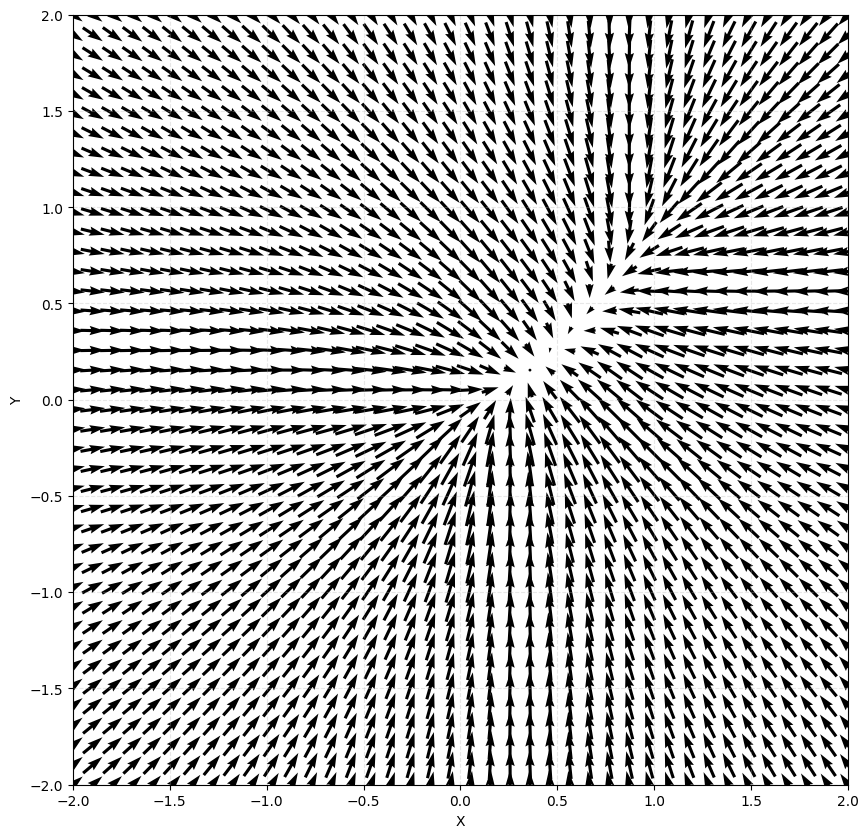

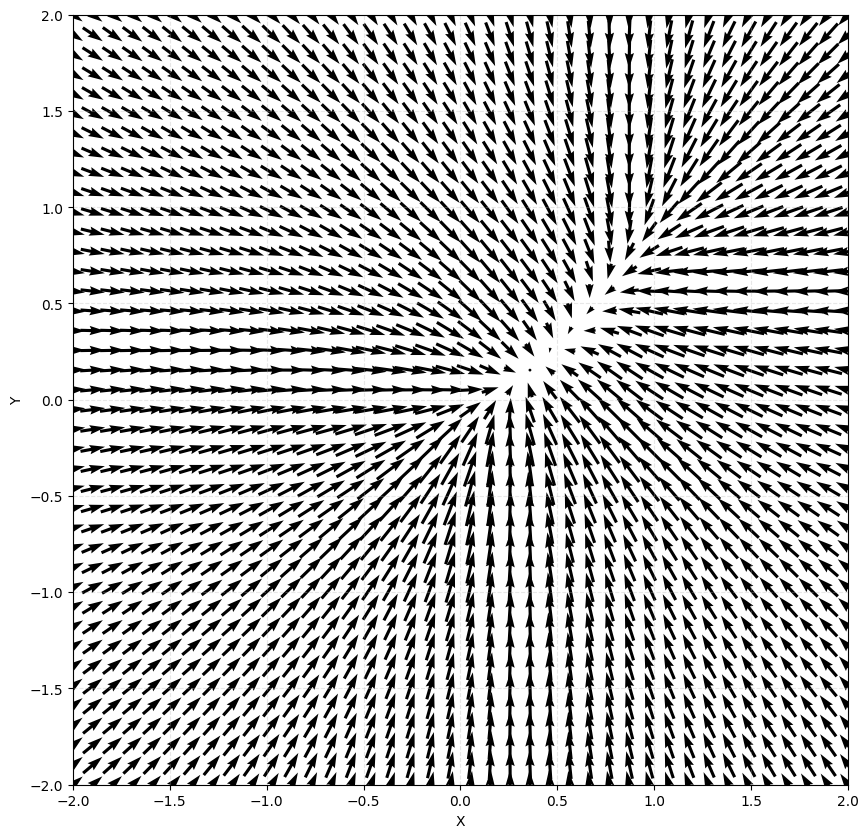

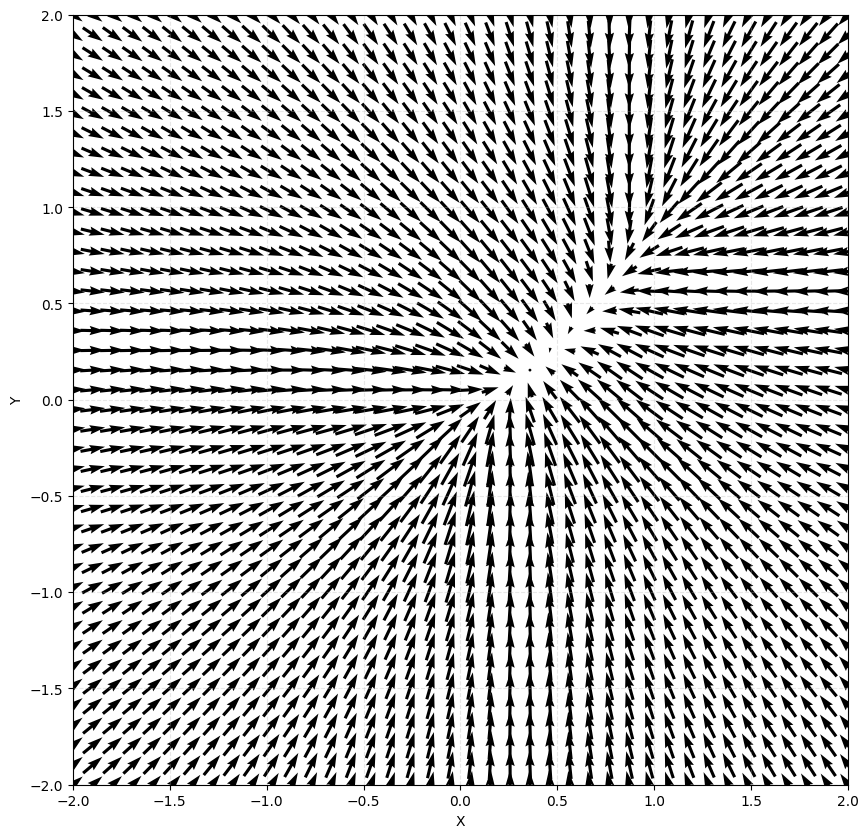

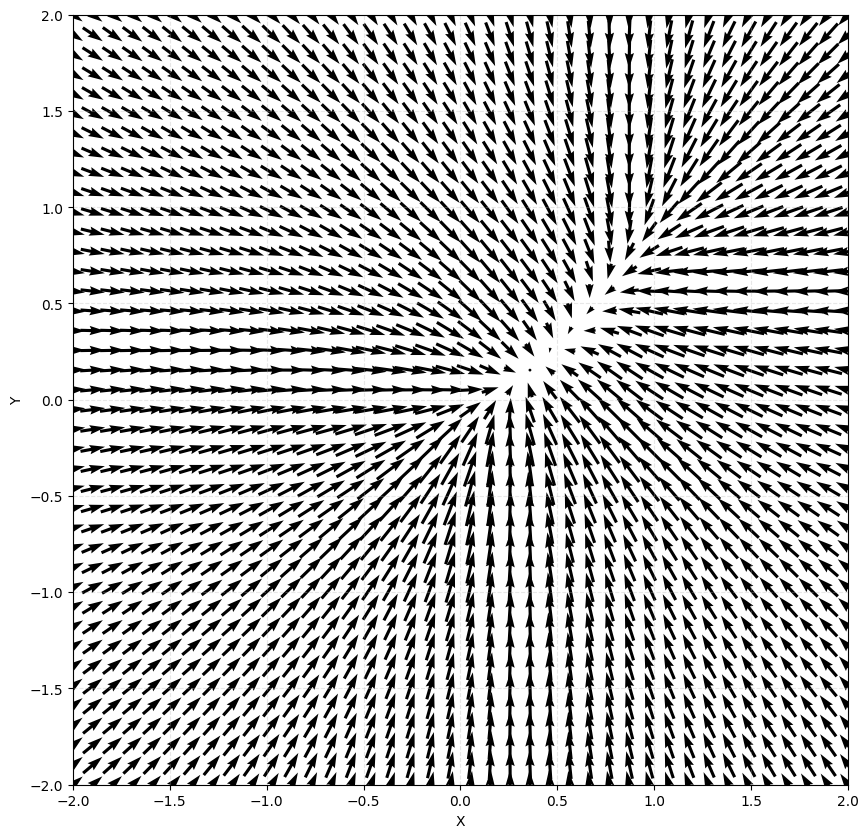

In [ ]:
plot_score_vector_field_modified(model,t=1.0,min_x=-2.0,max_x=2.0, sde=sde, train_score=TRAIN_SCORE)
plot_score_vector_field_modified(model,t=0.5,min_x=-2.0,max_x=2.0, sde=sde, train_score=TRAIN_SCORE)
plot_score_vector_field_modified(model,t=0.25,min_x=-2.0,max_x=2.0, sde=sde, train_score=TRAIN_SCORE)
plot_score_vector_field_modified(model,t=0.0,min_x=-2.0,max_x=2.0, sde=sde, train_score=TRAIN_SCORE)

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch import Tensor
from tqdm import tqdm

def run_backwards(model: torch.nn.Module, sde, x_start: Tensor, device, train_score, n_steps: int = 20, plot_evolution: bool = True, clip_max: float = .0 , clip_min: float = -1.0, div_threshold: float = -15, **kwargs):
    model = model.to(device)
    model.eval()

    n_traj = x_start.shape[0]
    ndim = x_start.dim() - 1

    time_grid = torch.linspace(sde.T_max, 0, n_steps)
    step_size = torch.tensor(sde.sigma**2 / n_steps)

    noise = torch.randn(size=(n_steps, *list(x_start.shape)))
    random_drift_grid_sample = torch.sqrt(step_size) * noise

    x_traj = [x_start]

    # Tracking which trajectories have stopped
    stopped = torch.zeros(x_start.shape[0], dtype=torch.bool)

    # Track the step at which each trajectory stops
    stopped_step = torch.full((x_start.shape[0],), n_steps, dtype=torch.int)

    if plot_evolution:
        fig, axs = plt.subplots(1, len(time_grid), figsize=(6*len(time_grid), 6))

    for idx, step_number in tqdm(enumerate(time_grid), total=n_steps):
        x = x_traj[idx].clone().detach().requires_grad_(True)
        random_drift_sample = random_drift_grid_sample[idx]
        model_estimate = model(x.to(device))

        if train_score:
            score_estimates = model_estimate
        else:
            level = torch.tensor(1.0)
            score_estimates = -sde._mult_first_dim(1 / (torch.sqrt(level) * sde.sigma), model_estimate) * sde.dim

        correction_term = (step_size * score_estimates)
        div = torch.zeros(x.shape[0])
        vector_length = torch.zeros(x.shape[0])

        for i in range(x.shape[0]):
            if stopped[i]:
                continue
            grads = []
            for d in range(score_estimates.shape[1]):
                grad = torch.autograd.grad(score_estimates[i, d], x, retain_graph=True, create_graph=True, allow_unused=True)[0]
                grads.append(grad[i, d].item() if grad is not None else 0.0)
            div[i] = sum(grads)
            vector_length[i] = torch.sum(score_estimates[i] ** 2)

        # Compute mask: continue only where condition holds
        mask = (div + vector_length > div_threshold) & (~stopped)
        change = torch.zeros_like(correction_term)
        change[mask] = correction_term[mask]

        # Mark stop step only once
        newly_stopped = (~mask) & (~stopped)
        stopped_step[newly_stopped] = idx

        # Update stop flags
        stopped = stopped | newly_stopped
        next_step = x.detach() + change

        if plot_evolution:
            axs[idx].scatter(x[:, 0].detach(), x[:, 1].detach())
            axs[idx].quiver(x[:, 0].detach(), x[:, 1].detach(), change[:, 0].detach(), change[:, 1].detach())
            axs[idx].set_title(f"Step={idx}")

        x_traj.append(next_step)

    # Compute average number of steps until stop
    avg_steps = stopped_step.float().mean().item()

    # Compute fraction of stopped trajectories
    num_stopped = (stopped_step < n_steps).sum().item()
    fraction_stopped = num_stopped / n_traj

    print(f"🔁 Average number of steps until stopping: {avg_steps:.2f} out of max {n_steps}")
    print(f"🛑 Fraction of stopped trajectories: {fraction_stopped * 100:.1f}% ({num_stopped} out of {n_traj})")


    output = torch.stack(x_traj)
    return output, time_grid


100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


🔁 Average number of steps until stopping: 6.39 out of max 10
🛑 Fraction of stopped trajectories: 72.7% (93 out of 128)


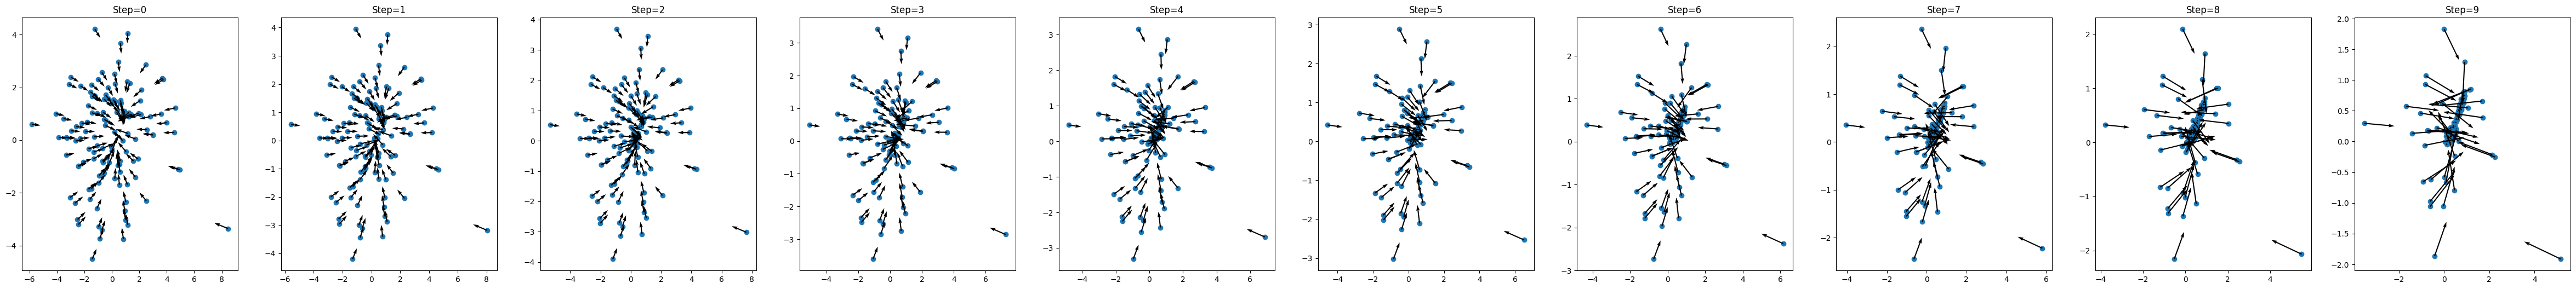

In [ ]:
x_start = torch.randn(size=next(enumerate(trainloader))[1].shape)*2*sde.sigma**2
output,time_grid = run_backwards(model,sde,x_start=x_start,n_steps=10,device=device, train_score=TRAIN_SCORE)

In [ ]:
!pip install celluloid

In [ ]:
from celluloid import Camera # getting the camera
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML # to show the animation in Jupyter
# the camera gets the fig we'll plot

fig, axs = plt.subplots(figsize=(7,7))
camera = Camera(fig)
x_ref = np.linspace(0,1,100)
for idx in range(output.shape[0]):
    axs.plot(x_ref, manifold_func(x_ref),color='tab:red')
    # Detach the tensor and convert to NumPy array before plotting
    axs.scatter(output[idx,:,0].detach().cpu().numpy(),output[idx,:,1].detach().cpu().numpy(),color='tab:blue')
    axs.set_xlim(-2.0,2.0)
    axs.set_ylim(-2.0,2.0)
    camera.snap()

animation = camera.animate() # animation ready
animation.save('diffusion_model_sampling.gif')
plt.close()

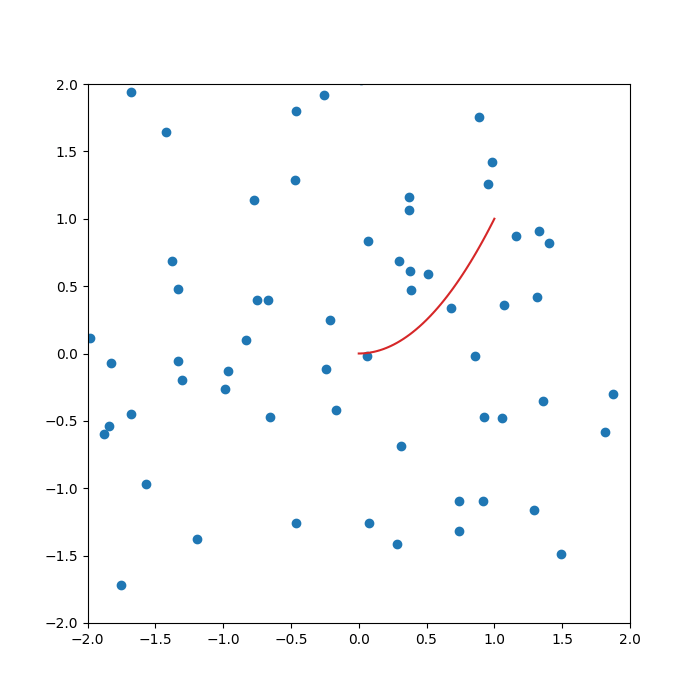

In [ ]:
from IPython.display import Image
display(Image(filename='diffusion_model_sampling.gif'))